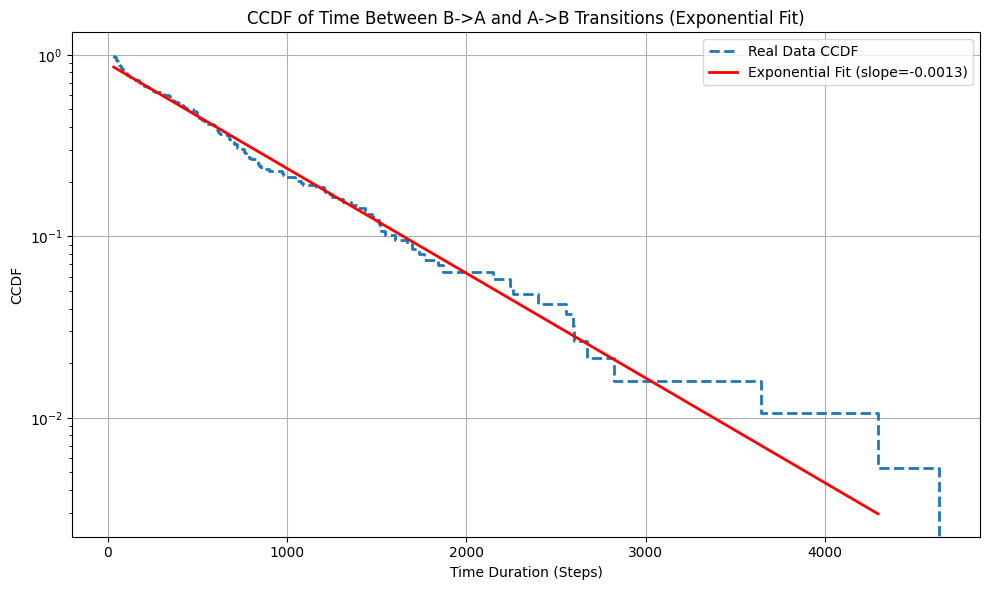

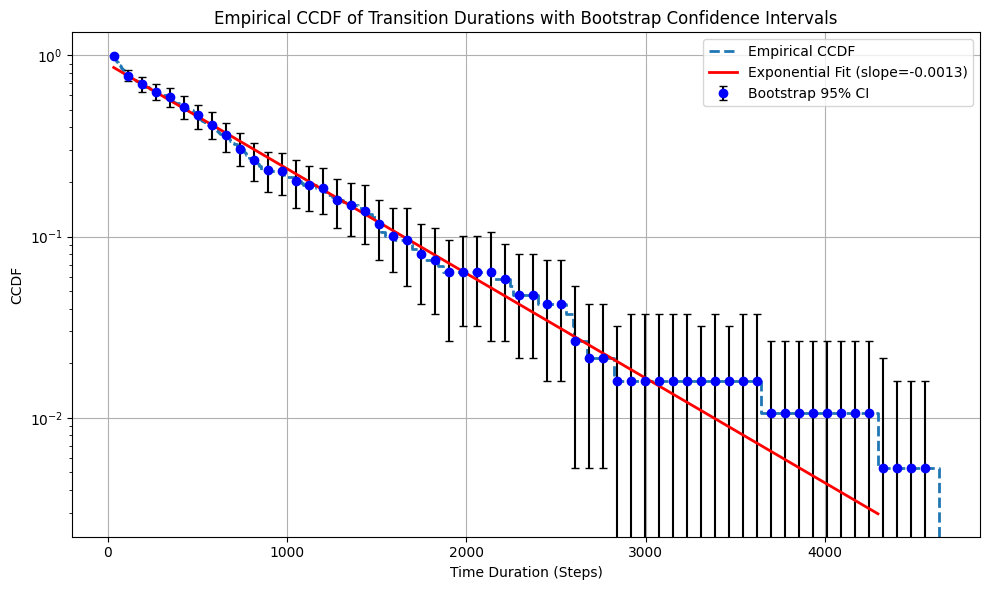

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress

# Load data
weights_file = r'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_best/predictions_checkpoint_7_Resnet_VAE_best.npy'
x_file = r'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy'
data = np.load(weights_file)
data_real = np.load(x_file)

# Extract predictions and real data
predictions = data.squeeze()  # Shape becomes (100000, 75)
real_data = data_real[:, 0, 63]  # Extract real zonal wind data at index 60

# Define bounds
upper_bound = 53.8 / 2.8935
lower_bound = 1.75 / 2.8935

# Function to calculate transition durations
def calculate_transition_durations(y_values, upper_bound, lower_bound):
    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False

    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:  
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:  
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None  
            above_upper = True
            below_lower = False

        if below_lower and transition_start is None:
            transition_start = i

    return times_between_transitions

# Compute transition durations for real data
real_durations = calculate_transition_durations(real_data, upper_bound, lower_bound)

# Compute CCDF
real_data_sorted = np.sort(real_durations)
ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

# Filter valid data (exclude zero or negative CCDF values)
valid_indices = ccdf_real > 0  # Avoid log(0) issues
x_fit = real_data_sorted[valid_indices]  # Keep x in linear scale
y_fit = np.log(ccdf_real[valid_indices])  # Apply log transformation to y

# Perform linear regression on log-transformed data
slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)

# Convert back to exponential form (y = e^(slope*x + intercept))
x_line = np.linspace(min(x_fit), max(x_fit), 100)
y_line = np.exp(slope * x_line + intercept)  # Convert back from log scale

# Plot CCDF and best-fit line
plt.figure(figsize=(10, 6))
plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
plt.plot(x_line, y_line, 'r-', label=f'Exponential Fit (slope={slope:.4f})', linewidth=2)

plt.xlabel('Time Duration (Steps)')
plt.ylabel('CCDF')
plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
plt.yscale("log")  # Keep y-axis in log scale
plt.xscale("linear")  # Keep x-axis in linear scale
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def bootstrap_ci(data, num_bootstraps=1000, confidence_level=0.95):
    sample_size = len(data)
    bootstrap_means = np.zeros(num_bootstraps)
    
    for i in range(num_bootstraps):
        bootstrap_sample = np.random.choice(data, size=sample_size, replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    
    ci_lower = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
    ci_upper = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
    
    return np.mean(data), ci_lower, ci_upper

# Create a grid of x values (time steps / durations)
x_grid = np.linspace(np.min(real_durations), np.max(real_durations), 60)

bootstrap_mean = []
ci_lower_vals = []
ci_upper_vals = []

for x in x_grid:
    valid_indices = (real_durations > x).astype(float)
    mean_val, lower, upper = bootstrap_ci(valid_indices)
    bootstrap_mean.append(mean_val)
    ci_lower_vals.append(lower)
    ci_upper_vals.append(upper)

bootstrap_mean = np.array(bootstrap_mean)
ci_lower_vals = np.array(ci_lower_vals)
ci_upper_vals = np.array(ci_upper_vals)

# Calculate error bars (difference from the bootstrap mean)
error_lower = bootstrap_mean - ci_lower_vals
error_upper = ci_upper_vals - bootstrap_mean

# Plot the empirical CCDF and the bootstrap estimates with error bars
plt.figure(figsize=(10, 6))
plt.step(real_data_sorted, ccdf_real, where='post', label='Empirical CCDF',
         linestyle='--', linewidth=2)
plt.errorbar(x_grid, bootstrap_mean, yerr=[error_lower, error_upper],
             fmt='o', color='blue', capsize=3, ecolor='black', label='Bootstrap 95% CI')
plt.plot(x_line, y_line, 'r-', label=f'Exponential Fit (slope={slope:.4f})', linewidth=2)

plt.xlabel('Time Duration (Steps)')
plt.ylabel('CCDF')
plt.yscale('log')
plt.title('Empirical CCDF of Transition Durations with Bootstrap Confidence Intervals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()